<a href="https://colab.research.google.com/github/diegoramfin/Pre-Trade-TCA-Suite-for-Algorithmic-Execution/blob/main/Pre_Trade_TCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-Trade TCA Suite for Algorithmic Execution

Suite leverages TCA functions and optimizes them to provide a map for a basket of trading orders that a desk normally encounters. Project's objective is to showcase these functions and the analystics which can be built upon them.

In [ ]:
#Step 1: Package Scientific Stack

import pandas as pd
import numpy as np
import statistics as st
import scipy
from scipy import stats
import scipy.optimize as spo
from scipy.optimize import minimize
from scipy.optimize import fsolve
from google.colab import files


In [ ]:
#Step 2: Select I/O Files
# Input file:
'''
In this section you will be prompted to upload an order file, it must strictly follow the following format:

Shape (ANY-NUMBER-HERE, **14**), columns must be 14 which are:

Index(['Number', 'TradeDate', 'Symbol', 'Side', 'Shares', 'Price',
       'Volatility', 'ADV', 'Beta', 'SideIndicator', 'Value', 'Weight', 'Size',
       'AlphaBp'],
      dtype='object')
'''
uploaded = files.upload()

uploaded_filename = list(uploaded.keys())[0]

PreTradeData = pd.read_csv(uploaded_filename)

# Output file:
TradersDilemmaFile="TradersDilemma.csv"
MinimizeCostFile="MinimizeCost.csv"
PriceImprovementFile="PriceImprovement.csv"

print(PreTradeData.head())
print(PreTradeData.shape)
print(PreTradeData.columns)

Saving Project-PreTrade-Data.csv to Project-PreTrade-Data (1).csv
   Number  TradeDate Symbol Side  Shares   Price  Volatility      ADV  Beta  \
0       1  4/21/2025    IBM  Buy  309300  236.22        0.39  5153500  0.76   
1       2  4/21/2025    TRV  Buy  145730  249.59        0.36  1616000  0.65   
2       3  4/21/2025    EMR  Buy  324790   96.42        0.55  3611800  1.12   
3       4  4/21/2025    IFF  Buy   21280   72.71        0.43  2113100  0.77   
4       5  4/21/2025     SO  Buy   50150   90.23        0.23  5008400  0.43   

   SideIndicator     Value  Weight    Size  AlphaBp  
0              1  73062846  0.1141  0.0600       76  
1              1  36372751  0.0568  0.0902       65  
2              1  31316252  0.0489  0.0899      112  
3              1   1547269  0.0024  0.0101       77  
4              1   4525035  0.0071  0.0100       43  
(25, 14)
Index(['Number', 'TradeDate', 'Symbol', 'Side', 'Shares', 'Price',
       'Volatility', 'ADV', 'Beta', 'SideIndicator', 'Value

In [ ]:
# Step 3. Define Market Impact Variables

# MI Parameters
a1=883.58
a2=0.35
a3=0.75
a4=0.82
b1=0.96
MIParams=[a1, a2, a3, a4, b1]


In [ ]:
# Step 4. User Defined TCA Pre-Trade Functions

# Pre-Trade TCA Functions
'''
Following section will have a comprehensive list of functions with an explanation of what they do and the args and params needed to run them.
'''

# Market Impact
def MI_calc(Size, Volatility, POV, MIParams):
    """
    Calculates the Market Impact (MI) in basis points.

    Args:
        Size: Size of the trade as a fraction of ADV.
        Volatility: Volatility of the stock.
        POV: Participation of Volume (fraction).
        MIParams: List of parameters [a1, a2, a3, a4, b1] for the MI calculation.

    Returns:
        The Market Impact in basis points.
    """
    a1, a2, a3, a4, b1 = MIParams
    mi = (a1*Size**a2*Volatility**a3) * (b1*POV**a4 + (1-b1))
    return mi

# Timing Risk
def TR_calc(Size, Volatility, POV):
    """
    Calculates the Timing Risk (TR) in basis points.

    Args:
        Size: Size of the trade as a fraction of ADV.
        Volatility: Volatility of the stock.
        POV: Participation of Volume (fraction).

    Returns:
        The Timing Risk in basis points.
    """
    tr = Volatility * ((1/3*1/250*Size*(1-POV)/POV )**0.5) * 10**4
    return tr

# Price Appreciation
def PA_calc(Side, Size, AlphaBp, POV):
    """
    Calculates the Price Appreciation (PA) in basis points.

    Args:
        Side: Side of the trade (1 for Buy, -1 for Sell).
        Size: Size of the trade as a fraction of ADV.
        AlphaBp: Alpha in basis points.
        POV: Participation of Volume (fraction).

    Returns:
        The Price Appreciation in basis points.
    """
    pa = Side * 1/2 * AlphaBp * Size * ((1 - POV)/POV)
    return pa

# POV to Trade Time
def POVToTime_calc(Size, POV):
    """
    Converts Participation of Volume (POV) to Trade Time in days.

    Args:
        Size: Size of the trade as a fraction of ADV.
        POV: Participation of Volume (fraction).

    Returns:
        The Trade Time in days.
    """
    tt = Size * ((1-POV)/POV)
    return tt

# Trade Time To POV
def TimeToPOV_calc(Size, Time):
    """
    Converts Trade Time in days to Participation of Volume (POV).

    Args:
        Size: Size of the trade as a fraction of ADV.
        Time: Trade Time in days.

    Returns:
        The Participation of Volume (fraction).
    """
    pov = Size / (Time+Size)
    return pov

# Expected Cost
def ExpCost_calc(MI, PA):
    """
    Calculates the Expected Cost in basis points.

    Args:
        MI: Market Impact in basis points.
        PA: Price Appreciation in basis points.

    Returns:
        The Expected Cost in basis points.
    """
    expCost = MI + PA
    return expCost

# Expected Price
def ExpPrice_calc(Side, P0, MI, PA):
    """
    Calculates the Expected Price.

    Args:
        Side: Side of the trade (1 for Buy, -1 for Sell).
        P0: Initial Price.
        MI: Market Impact in basis points.
        PA: Price Appreciation in basis points.

    Returns:
        The Expected Price per share.
    """
    expPrice = P0*(1+Side*(MI + PA)/10000)
    return expPrice


# Trade Strategy Optimization Functions

# Traders Dilemma Objective Function
def TradersDilemma_OptCalc(POV, Size, Volatility, Lambda, MIParams):
    """
    Calculates the objective function for the Traders Dilemma optimization.
    Do I move the markets or do the markets move me?

    Args:
        POV: Participation of Volume (fraction).
        Size: Size of the trade as a fraction of ADV.
        Volatility: Volatility of the stock.
        Lambda: Risk aversion parameter.
        MIParams: List of parameters [a1, a2, a3, a4, b1] for the MI calculation.

    Returns:
        The objective function value (MI + Lambda * TR).
    """
    MI = MI_calc(Size, Volatility, POV, MIParams)
    TR = TR_calc(Size, Volatility, POV)
    ObjFun = MI + (Lambda*TR)
    return ObjFun

#Minimze Cost Optimizer
def MinCost_OptCalc(POV, Size, Volatility, AlphaBp, MIParams, Side):
    """
    Calculates the objective function for the Minimize Cost optimization.
    How can I minimize the cost of my trade?

    Args:
        POV: Participation of Volume (fraction).
        Size: Size of the trade as a fraction of ADV.
        Volatility: Volatility of the stock.
        AlphaBp: Alpha in basis points.
        MIParams: List of parameters [a1, a2, a3, a4, b1] for the MI calculation.
        Side: Side of the trade (1 for Buy, -1 for Sell).

    Returns:
        The objective function value (MI + PA for Buy, MI - PA for Sell).
    """
    MI = MI_calc(Size, Volatility, POV, MIParams)
    PA = PA_calc(Side, Size, AlphaBp, POV)

    # Elegant, fork fix for Min Cost that is Context Aware
    if Side == 1:  # BUY
        ObjFun = MI + PA
    else:  # SELL
        ObjFun = MI - PA
    return ObjFun

# Maximize Price Improvement Trade Strategy Optimization
def PriceImprovement_OptCalc(POV, Size, Volatility, Bid, MIParams):
    """
    Calculates the objective function for the Maximize Price Improvement optimization.
    How can I maximize the price improvement of my trade?

    Args:
        POV: Participation of Volume (fraction).
        Size: Size of the trade as a fraction of ADV.
        Volatility: Volatility of the stock.
        Bid: Bid price in basis points.
        MIParams: List of parameters [a1, a2, a3, a4, b1] for the MI calculation.

    Returns:
        The negative ratio of (Bid - MI) to TR.
    """
    MI = MI_calc(Size, Volatility, POV, MIParams)
    TR = TR_calc(Size, Volatility, POV)
    net_benefit = Bid - MI
    if net_benefit <= 0 or TR <= 0:
        return 1e6  # Very large value to indicate infeasible solution
    return -(net_benefit / TR)

In [ ]:
# Step 5: POV Iteration on Basket of Stocks Order
'''
Following section will run a basket of stocks through a POV (percentage of volume) strategy, iterating the rates whilst calculating the TCA components.
'''
import pandas as pd
POV_rates = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]        # 5‒30 %

records = []            # per-stock, per-POV
summary_rows = []       # weighted averages, shows how well each rate did on the aggregate level

for pov in POV_rates:

    tmp = []
    for _, row in PreTradeData.iterrows():
        mi  = MI_calc(row.Size, row.Volatility, pov, MIParams)
        pa  = PA_calc(row.SideIndicator, row.Size, row.AlphaBp, pov)
        tr  = TR_calc(row.Size, row.Volatility, pov)
        t   = POVToTime_calc(row.Size, pov)
        ec  = ExpCost_calc(mi, pa)
        ep  = ExpPrice_calc(row.SideIndicator, row.Price, mi, pa)

        tmp.append(dict(Symbol=row.Symbol, POV=pov*100, Time=t,
                        MI=mi, PA=pa, TR=tr,
                        ExpCost=ec, ExpPrice=ep,
                        Weight=row.Weight))
    df_tmp = pd.DataFrame(tmp)
    records.append(df_tmp)

    wavg = (df_tmp[["POV","Time","MI","PA","TR","ExpCost","ExpPrice"]]
            .multiply(df_tmp.Weight, axis=0).sum())
    summary_rows.append(wavg)

df_pov_all = pd.concat(records, ignore_index=True)
df_pov_all.to_csv("POV_Strategy_AllStocks.csv", index=False)

pov_summary = pd.DataFrame(summary_rows)
pov_summary.to_csv("POV_Strategy_Summary.csv")


In [ ]:
# Step 6: Trade Time Iteration on Basket of Stocks Order
'''
Following section will run a basket of stocks through a Trade Time strategy, iterating the times whilst calculating the TCA components.
'''

import pandas as pd
TRADE_TIMES = [0.25, 0.50, 0.75, 1.00, 1.50, 2.00]     # days

records = []                # per-stock, per-Trade Time
summary_rows = []           # weighted averages, shows how well each Trade Time did on the aggregate level

for tt in TRADE_TIMES:

    tmp = []
    for _, row in PreTradeData.iterrows():
        pov = TimeToPOV_calc(row.Size, tt)
        mi  = MI_calc(row.Size, row.Volatility, pov, MIParams)
        pa  = PA_calc(row.SideIndicator, row.Size, row.AlphaBp, pov)
        tr  = TR_calc(row.Size, row.Volatility, pov)
        ec  = ExpCost_calc(mi, pa)
        ep  = ExpPrice_calc(row.SideIndicator, row.Price, mi, pa)

        tmp.append(dict(Symbol=row.Symbol, POV=pov*100, Time=tt,
                        MI=mi, PA=pa, TR=tr,
                        ExpCost=ec, ExpPrice=ep,
                        Weight=row.Weight))
    df_tmp = pd.DataFrame(tmp)
    records.append(df_tmp)

    wavg = (df_tmp[["POV","Time","MI","PA","TR","ExpCost","ExpPrice"]]
            .multiply(df_tmp.Weight, axis=0).sum())
    summary_rows.append(wavg)

df_time_all = pd.concat(records, ignore_index=True)
df_time_all.to_csv("TradeTime_Strategy_AllStocks.csv", index=False)

time_summary = pd.DataFrame(summary_rows)
time_summary.to_csv("TradeTime_Strategy_Summary.csv")


In [ ]:
# Step 7: Traders Dilemma Optimization
'''
Solve the Traders Dilemma optimization for each stock via a loop, whilst calculating TCA components.
'''
# Setup Arrays to store data for Optimization Loop
POV=[]
TIME=[]
MI=[]
PA=[]
TR=[]
ExpCost=[]
ExpPrice=[]
SideIndicator = [] # Added SideIndicator

# Set Lambda, configurable to desired level.
Lambda=0.40

# Loop over all orders in the pre-trade file and solve traders dilemma.
for i in range(len(PreTradeData['Symbol'])):

    Symbol = PreTradeData['Symbol'][i]
    Side = PreTradeData['SideIndicator'][i]
    Size = PreTradeData['Size'][i]
    Volatility = PreTradeData['Volatility'][i]
    AlphaBp = PreTradeData['AlphaBp'][i]
    P0 = PreTradeData['Price'][i]

    # Upper and Lower Bounds
    '''
    This was done to force realistic POV rates, without any bounds it will infinitely minimize.
    '''
    MyBounds = [[0.00001,0.9999]]
    #initial guess, configurable for desired level.
    x0 = 0.5
    # solve the minimization problem
    results = minimize(TradersDilemma_OptCalc, x0, bounds = MyBounds, args = (Size, Volatility, Lambda, MIParams))
    #print(results) Sanity check for value without opening results file.
    OptPOV=results.x

    # Calculate all TCA costs and Trade Time
    mi = MI_calc(Size, Volatility, OptPOV, MIParams)
    tr = TR_calc(Size, Volatility, OptPOV)
    pa = PA_calc(Side, Size, AlphaBp, OptPOV)
    tradeTime = POVToTime_calc(Size, OptPOV)
    expCost=ExpCost_calc(mi, pa)
    expPrice=ExpPrice_calc(Side, P0, mi, pa)

    POV.append(OptPOV)
    TIME.append(tradeTime)
    MI.append(mi)
    PA.append(pa)
    TR.append(tr)
    ExpCost.append(expCost)
    ExpPrice.append(expPrice)
    SideIndicator.append(Side) # Appended SideIndicator


# Remove the Brackets from the output
POV_clean = [x.item() for x in POV]
Time_clean  = [x.item() for x in TIME]
MI_clean  = [x.item() for x in MI]
PA_clean  = [x.item() for x in PA]
TR_clean  = [x.item() for x in TR]
ExpCost_clean  = [x.item() for x in ExpCost]
ExpPrice_clean  = [x.item() for x in ExpPrice]
SideIndicator_clean = [x for x in SideIndicator] # Clean SideIndicator


# Create Results Dataframe
df = pd.DataFrame({
    'POV': POV_clean,
    'Time': Time_clean,
    'MI': MI_clean,
    'PA': PA_clean,
    'TR': TR_clean,
    'ExpCost': ExpCost_clean,
    'ExpPrice': ExpPrice_clean,
    'SideIndicator': SideIndicator_clean # Added SideIndicator
})


# Save DF to CSF for Traders Dilemma
df.to_csv(TradersDilemmaFile, index = False, header=True)

In [ ]:
# Step 8: Minimize Cost Optimization
'''
Solve the Minimize Cost Optimization for each stock via a loop, whilst calculating TCA components.
'''
# Setup Arrays to store data for Optimization Loop
POV, TIME, MI, PA, TR = [], [], [], [], []
ExpCost, ExpPrice      = [], []
SideIndicator = [] # Added SideIndicator

# Loop over all orders in the pre-trade file and solve minimize cost optimization.
for i in range(len(PreTradeData)):

    side       = PreTradeData['SideIndicator'][i]   # +1 Buy, –1 Sell
    size       = PreTradeData['Size'][i]
    vol        = PreTradeData['Volatility'][i]
    alpha_bp   = PreTradeData['AlphaBp'][i]
    price0     = PreTradeData['Price'][i]

    # Upper and Lower Bounds
    '''
    This was done to force realistic POV rates, without any bounds it will infinitely minimize.
    '''

    if side == 1:
      bounds = [[0.00001,0.30]]
    else:
      bounds = [[0.001, 0.30]]

    x0     = 0.05

    res = minimize(MinCost_OptCalc, x0, bounds=bounds,
                   args=(size, vol, alpha_bp, MIParams, side),
                   method = 'L-BFGS-B')

    pov_star = res.x.item()

    mi  = MI_calc(size, vol, pov_star, MIParams)
    pa  = PA_calc(side, size, alpha_bp, pov_star)
    tr  = TR_calc(size, vol, pov_star)
    t   = POVToTime_calc(size, pov_star)
    ec  = ExpCost_calc(mi, pa)
    ep  = ExpPrice_calc(side, price0, mi, pa)

    POV.append(pov_star);  TIME.append(t)
    MI.append(mi);         PA.append(pa);   TR.append(tr)
    ExpCost.append(ec);    ExpPrice.append(ep)
    SideIndicator.append(side) # Appended SideIndicator

# Create Results Dataframe
df_mincost = pd.DataFrame({
    "POV": POV, "Time": TIME, "MI": MI, "PA": PA,
    "TR": TR, "ExpCost": ExpCost, "ExpPrice": ExpPrice,
    'SideIndicator': SideIndicator # Added SideIndicator
})

# Save DF to CSF for Minimize Cost
MinimizeCostFile = "MinimizeCost_Results.csv"
df_mincost.to_csv(MinimizeCostFile, index=False, header=True)

In [ ]:
# Step 10: Price Improvement Optimization
'''
Solve the Price Improvement Optimization for each stock via a loop, whilst calculating TCA components.
'''
#Important Value Bid BP must be configured. 75bp is placeholder.

BID_BP          = 75.0
PriceImprovementFile = "PriceImprovement_Results.csv"

POV, TIME, MI, PA, TR = [], [], [], [], []
ExpCost, ExpPrice      = [], []
SideIndicator = [] # Added SideIndicator


for i in range(len(PreTradeData)):

    side       = PreTradeData['SideIndicator'][i]   # +1 Buy, –1 Sell
    size       = PreTradeData['Size'][i]
    vol        = PreTradeData['Volatility'][i]
    alpha_bp   = PreTradeData['AlphaBp'][i]
    price0     = PreTradeData['Price'][i]


    # Make BID_BP configurable to each order
    # You would retrieve the bid price for the current order here.
    # For example, if your DataFrame has a 'BidPrice' column:
    # BID_BP = PreTradeData['BidPrice'][i]
    # For now, keeping it as a placeholder:
    BID_BP          = 75.0


    bounds = [(0.00001, 0.9999)]
    x0     = 0.05

    res = minimize(PriceImprovement_OptCalc, x0, bounds=bounds,
                   args=(size, vol, BID_BP, MIParams))

    pov_star = res.x.item()

    mi  = MI_calc(size, vol, pov_star, MIParams)                 # bp
    pa  = PA_calc(side, size, alpha_bp, pov_star)                # bp
    tr  = TR_calc(size, vol, pov_star)                           # bp
    t   = POVToTime_calc(size, pov_star)                         # days
    ec  = ExpCost_calc(mi, pa)                                   # bp
    ep  = ExpPrice_calc(side, price0, mi, pa)                    # $/sh

    POV.append(pov_star);  TIME.append(t)
    MI.append(mi);         PA.append(pa);   TR.append(tr)
    ExpCost.append(ec);    ExpPrice.append(ep)
    SideIndicator.append(side) # Appended SideIndicator


df_priceimp = pd.DataFrame({
    "POV": POV, "Time": TIME, "MI": MI, "PA": PA, "TR": TR,
    "ExpCost": ExpCost, "ExpPrice": ExpPrice,
    'SideIndicator': SideIndicator # Added SideIndicator
})
df_priceimp.to_csv(PriceImprovementFile, index=False)

weights = PreTradeData["Weight"].values
priceimp_summary = (df_priceimp[["POV","Time","MI","PA","TR",
                                 "ExpCost","ExpPrice"]]
                    .multiply(weights, axis=0).sum())

# Post Trade Analytics
This section explores the data resulting from the TCA fucntions, through plotting and charting of the data the goal is to provide insights into the execution.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Load the summary data from the CSV files
pov_summary = pd.read_csv("POV_Strategy_Summary.csv")
time_summary = pd.read_csv("TradeTime_Strategy_Summary.csv")
traders_dilemma_results = pd.read_csv("TradersDilemma.csv")
minimize_cost_results = pd.read_csv("MinimizeCost_Results.csv")
price_improvement_results = pd.read_csv("PriceImprovement_Results.csv")

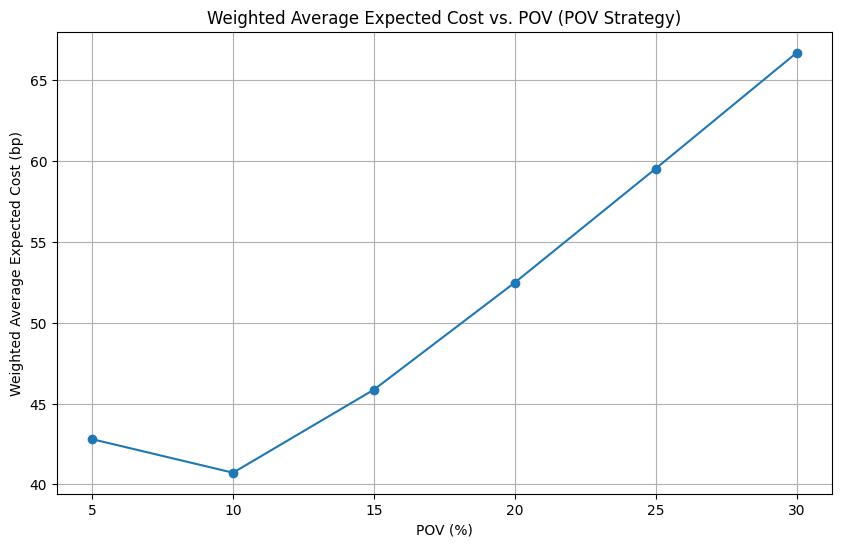

In [ ]:
# Plot Expected Cost vs. POV for POV Strategy
'''
Likely will see an increase in costs as POV rate increase.
'''
plt.figure(figsize=(10, 6))
plt.plot(pov_summary['POV'], pov_summary['ExpCost'], marker='o')
plt.xlabel('POV (%)')
plt.ylabel('Weighted Average Expected Cost (bp)')
plt.title('Weighted Average Expected Cost vs. POV (POV Strategy)')
plt.grid(True)
plt.show()

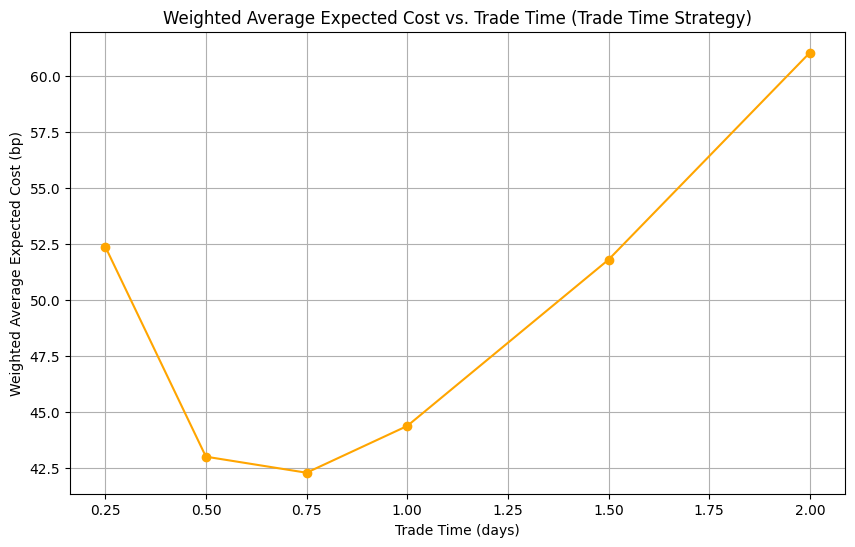

In [ ]:
# Plot Expected Cost vs. Time for Trade Time Strategy
'''
Likely will see an increase in costs as Trade Time increase.
'''
plt.figure(figsize=(10, 6))
plt.plot(time_summary['Time'], time_summary['ExpCost'], marker='o', color='orange')
plt.xlabel('Trade Time (days)')
plt.ylabel('Weighted Average Expected Cost (bp)')
plt.title('Weighted Average Expected Cost vs. Trade Time (Trade Time Strategy)')
plt.grid(True)
plt.show()

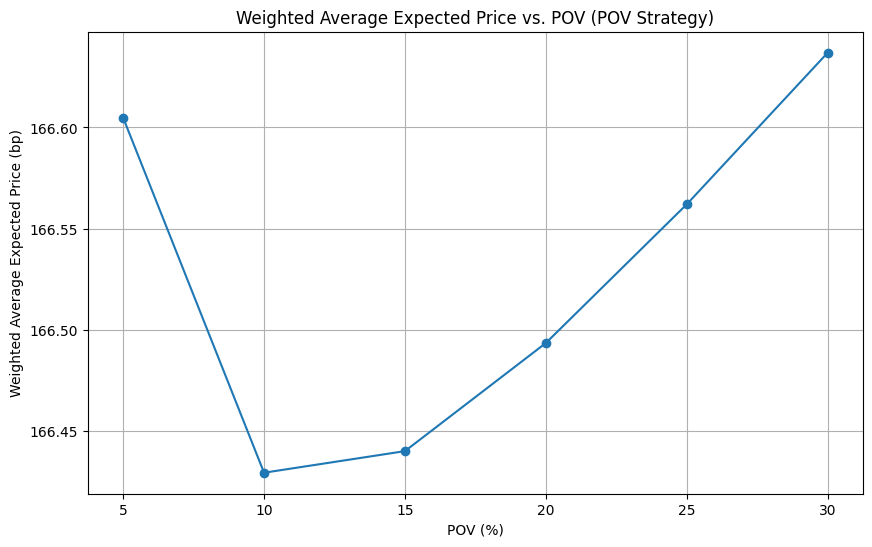

In [98]:
# Plot Expected Price vs. POV for POV Strategy
'''
Likely will see an increase in costs as POV rate increase.
'''
plt.figure(figsize=(10, 6))
plt.plot(pov_summary['POV'], pov_summary['ExpPrice'], marker='o')
plt.xlabel('POV (%)')
plt.ylabel('Weighted Average Expected Price (bp)')
plt.title('Weighted Average Expected Price vs. POV (POV Strategy)')
plt.grid(True)
plt.show()

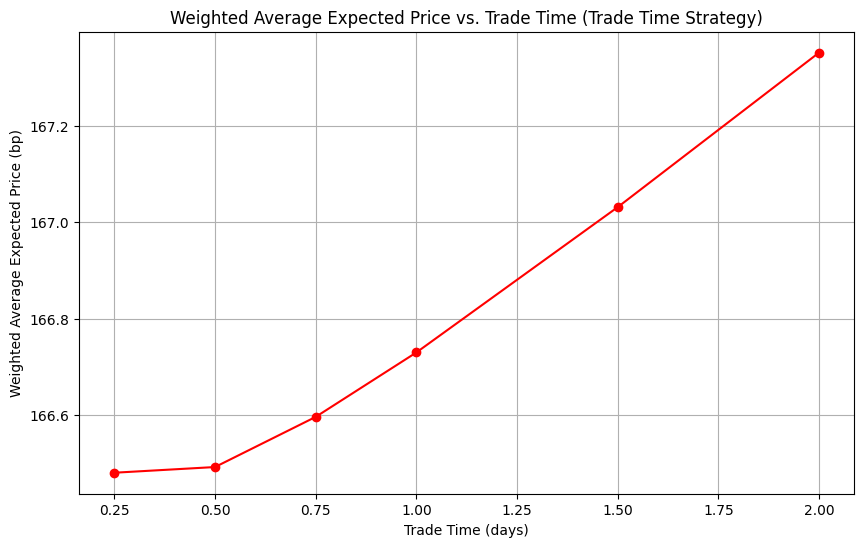

In [99]:
# Plot Expected Price vs. Time for Trade Time Strategy
'''
Likely will see an increase in costs as Trade Time increase.
'''
plt.figure(figsize=(10, 6))
plt.plot(time_summary['Time'], time_summary['ExpPrice'], marker='o', color='red')
plt.xlabel('Trade Time (days)')
plt.ylabel('Weighted Average Expected Price (bp)')
plt.title('Weighted Average Expected Price vs. Trade Time (Trade Time Strategy)')
plt.grid(True)
plt.show()

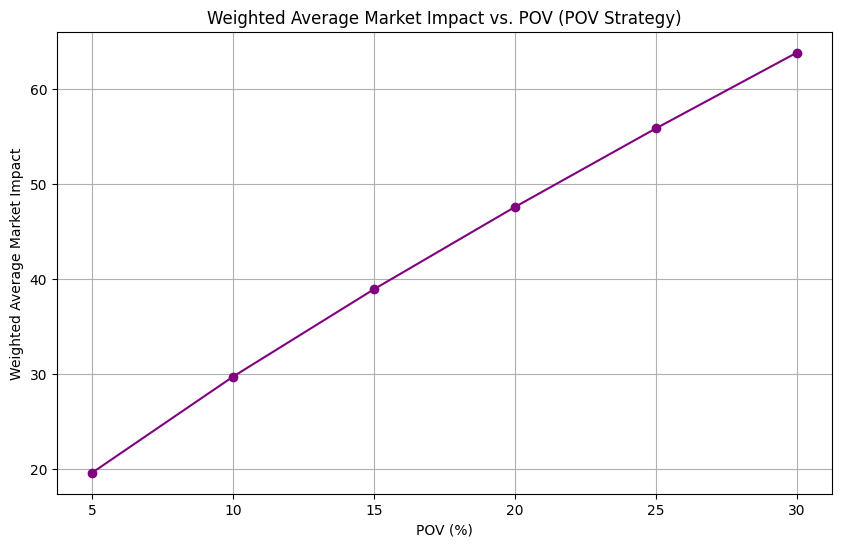

In [ ]:
# Plot Market Impact vs. POV for POV Strategy
'''
Likely will see an increase in MI as POV rate increase.
'''
plt.figure(figsize=(10, 6))
plt.plot(pov_summary['POV'], pov_summary['MI'], marker='o', color='purple')
plt.xlabel('POV (%)')
plt.ylabel('Weighted Average Market Impact')
plt.title('Weighted Average Market Impact vs. POV (POV Strategy)')
plt.grid(True)
plt.show()

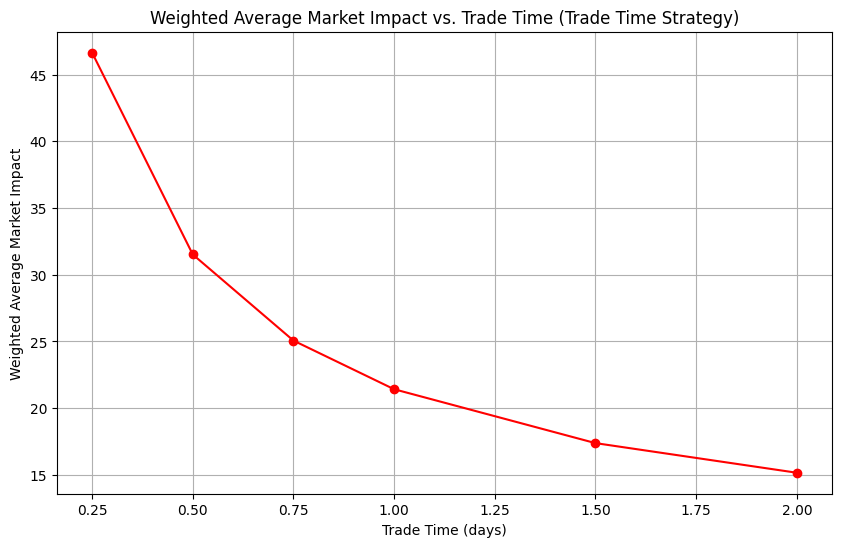

In [ ]:
# Plot Market Impact vs. Time for Trade Time Strategy
'''
Likely will see a decrease in MI as Trade Time increase.
'''
plt.figure(figsize=(10, 6))
plt.plot(time_summary['Time'], time_summary['MI'], marker='o', color='red')
plt.xlabel('Trade Time (days)')
plt.ylabel('Weighted Average Market Impact')
plt.title('Weighted Average Market Impact vs. Trade Time (Trade Time Strategy)')
plt.grid(True)
plt.show()

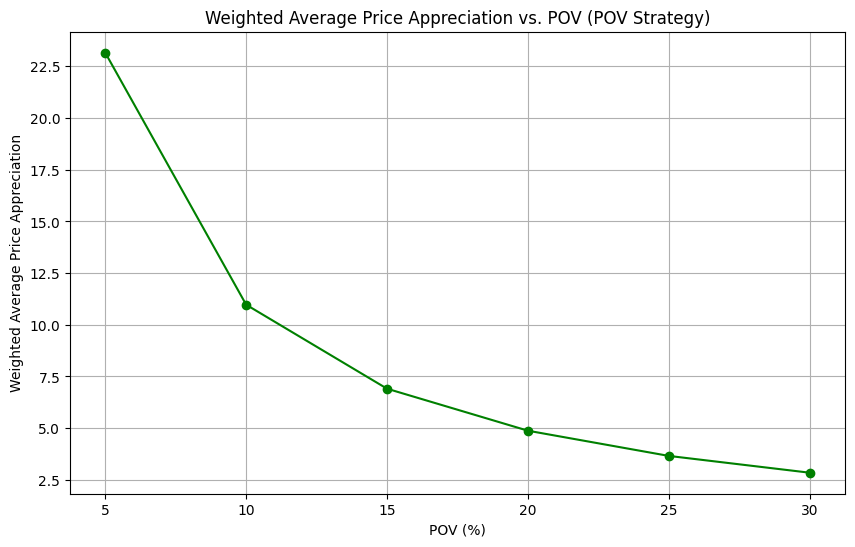

In [92]:
# Plot Price Appreciation vs. POV for POV Strategy
'''
Likely will see a decrease in PA as POV rate increase.
'''
plt.figure(figsize=(10, 6))
plt.plot(pov_summary['POV'], pov_summary['PA'], marker='o', color='green')
plt.xlabel('POV (%)')
plt.ylabel('Weighted Average Price Appreciation')
plt.title('Weighted Average Price Appreciation vs. POV (POV Strategy)')
plt.grid(True)
plt.show()

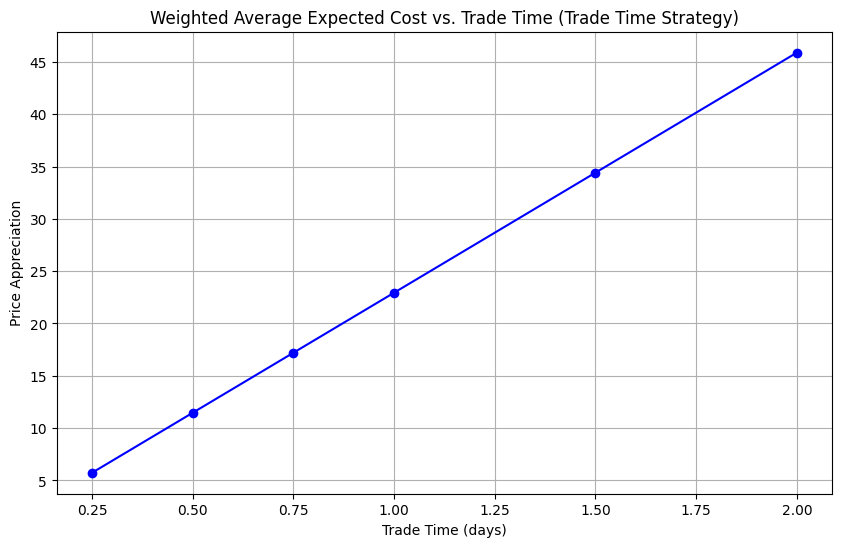

In [94]:
# Plot Price Appreciation vs. Time for Trade Time Strategy
'''
Likely will see an increase in Price Appreciation as Trade Time increase.
'''
plt.figure(figsize=(10, 6))
plt.plot(time_summary['Time'], time_summary['PA'], marker='o', color='blue')
plt.xlabel('Trade Time (days)')
plt.ylabel('Price Appreciation')
plt.title('Weighted Average Price Appreciation vs. Trade Time (Trade Time Strategy)')
plt.grid(True)
plt.show()

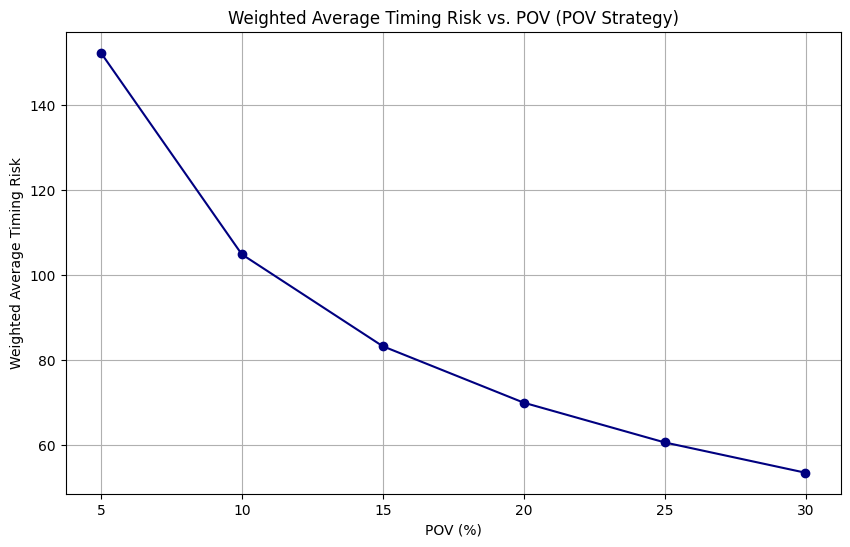

In [89]:
# Plot Timing Risk vs. POV for POV Strategy
'''
Likely will see a decrease in TR as POV rate increase.
'''
plt.figure(figsize=(10, 6))
plt.plot(pov_summary['POV'], pov_summary['TR'], marker='o', color='navy')
plt.xlabel('POV (%)')
plt.ylabel('Weighted Average Timing Risk')
plt.title('Weighted Average Timing Risk vs. POV (POV Strategy)')
plt.grid(True)
plt.show()

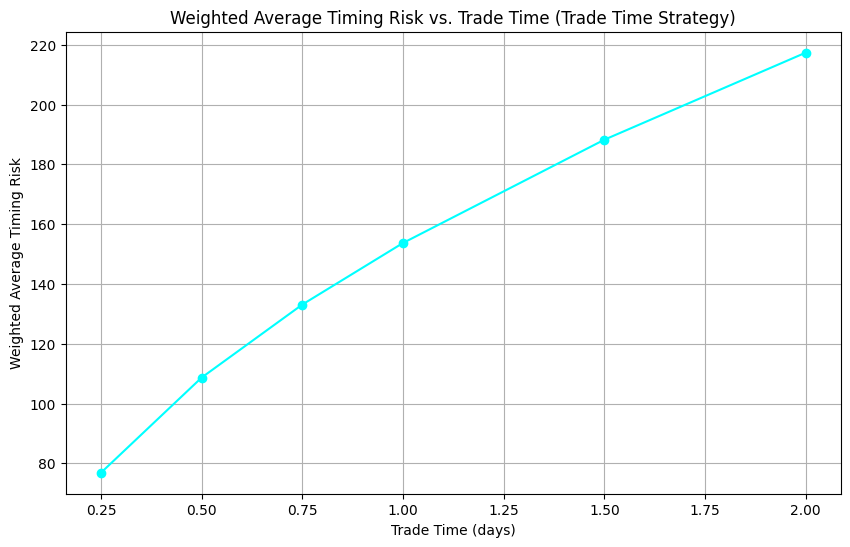

In [95]:
# Plot Timing Risk vs. Time for Trade Time Strategy
'''
Likely will see an increase in TR as Trade Time increase.
'''
plt.figure(figsize=(10, 6))
plt.plot(time_summary['Time'], time_summary['TR'], marker='o', color='cyan')
plt.xlabel('Trade Time (days)')
plt.ylabel('Weighted Average Timing Risk')
plt.title('Weighted Average Timing Risk vs. Trade Time (Trade Time Strategy)')
plt.grid(True)
plt.show()

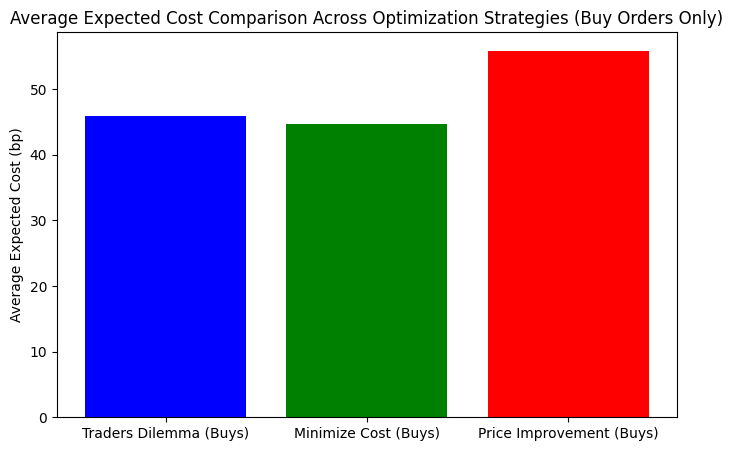

In [96]:
# Optimization Strategy Comparison (Summary Statistics)

# Filter for buy orders (SideIndicator == 1)
traders_dilemma_buys = traders_dilemma_results[traders_dilemma_results['SideIndicator'] == 1]
minimize_cost_buys = minimize_cost_results[minimize_cost_results['SideIndicator'] == 1]
price_improvement_buys = price_improvement_results[price_improvement_results['SideIndicator'] == 1]


# For a simple comparison, let's look at the average Expected Cost for each optimization
avg_exp_cost_dilemma = traders_dilemma_buys['ExpCost'].mean()
avg_exp_cost_mincost = minimize_cost_buys['ExpCost'].mean()
avg_exp_cost_priceimp = price_improvement_buys['ExpCost'].mean()

strategies = ['Traders Dilemma (Buys)', 'Minimize Cost (Buys)', 'Price Improvement (Buys)']
avg_exp_costs = [avg_exp_cost_dilemma, avg_exp_cost_mincost, avg_exp_cost_priceimp]

plt.figure(figsize=(8, 5))
plt.bar(strategies, avg_exp_costs, color=['blue', 'green', 'red'])
plt.ylabel('Average Expected Cost (bp)')
plt.title('Average Expected Cost Comparison Across Optimization Strategies (Buy Orders Only)')
plt.show()

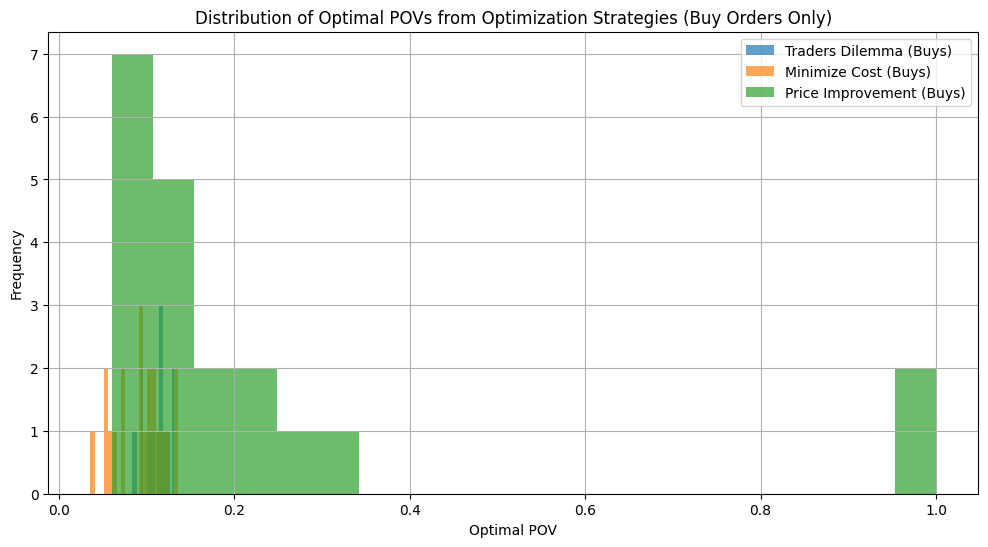

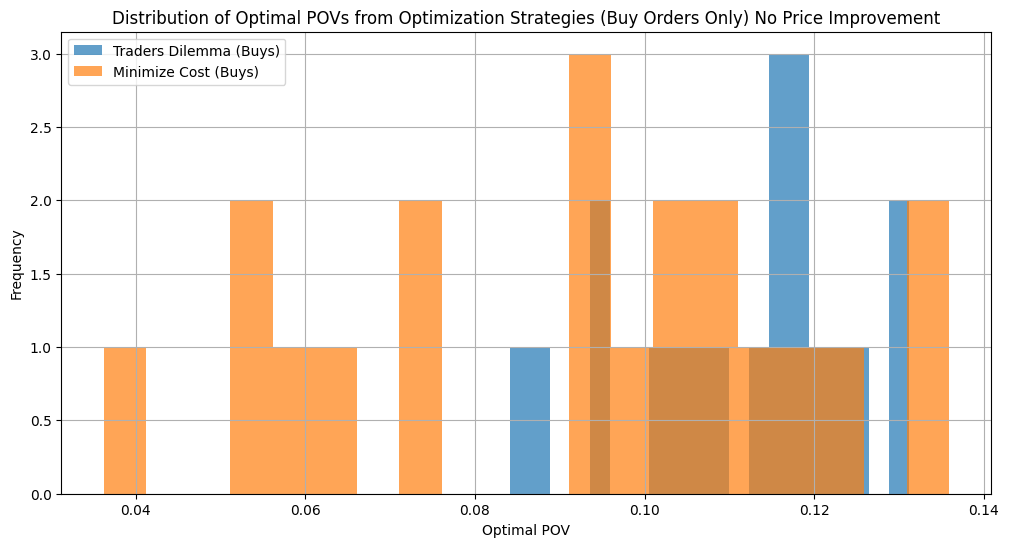

In [ ]:
# Distribution of Optimal POVs from Optimization Strategies

plt.figure(figsize=(12, 6))
plt.hist(traders_dilemma_buys['POV'], bins=20, alpha=0.7, label='Traders Dilemma (Buys)')
plt.hist(minimize_cost_buys['POV'], bins=20, alpha=0.7, label='Minimize Cost (Buys)')
plt.hist(price_improvement_buys['POV'], bins=20, alpha=0.7, label='Price Improvement (Buys)')
plt.xlabel('Optimal POV')
plt.ylabel('Frequency')
plt.title('Distribution of Optimal POVs from Optimization Strategies (Buy Orders Only)')
plt.legend()
plt.grid(True)
plt.show()

# Distribution of Optimal POVs from Optimization Strategies

plt.figure(figsize=(12, 6))
plt.hist(traders_dilemma_buys['POV'], bins=20, alpha=0.7, label='Traders Dilemma (Buys)')
plt.hist(minimize_cost_buys['POV'], bins=20, alpha=0.7, label='Minimize Cost (Buys)')
plt.xlabel('Optimal POV')
plt.ylabel('Frequency')
plt.title('Distribution of Optimal POVs from Optimization Strategies (Buy Orders Only) No Price Improvement')
plt.legend()
plt.grid(True)
plt.show()

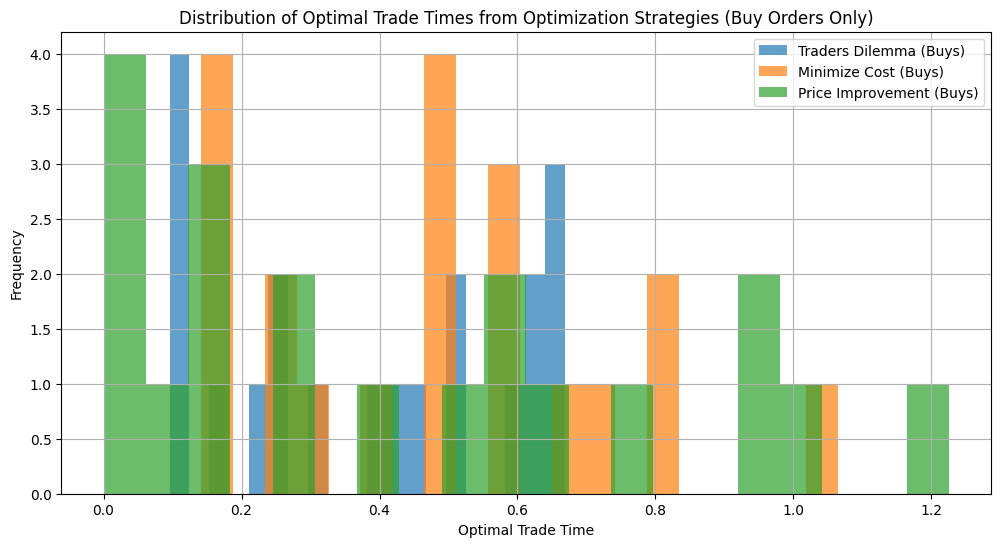

In [ ]:
# Distribution of Optimal Trade Times from Optimization Strategies

plt.figure(figsize=(12, 6))
plt.hist(traders_dilemma_buys['Time'], bins=20, alpha=0.7, label='Traders Dilemma (Buys)')
plt.hist(minimize_cost_buys['Time'], bins=20, alpha=0.7, label='Minimize Cost (Buys)')
plt.hist(price_improvement_buys['Time'], bins=20, alpha=0.7, label='Price Improvement (Buys)')
plt.xlabel('Optimal Trade Time')
plt.ylabel('Frequency')
plt.title('Distribution of Optimal Trade Times from Optimization Strategies (Buy Orders Only)')
plt.legend()
plt.grid(True)
plt.show()